### Setup: Imports and Global Configuration

This cell:

- Imports all the Python libraries needed for the Iris experiments:
  - `numpy`, `pandas` for numerical + tabular data handling.
  - `matplotlib`, `seaborn` for plotting.
  - `sklearn` modules for loading the dataset, preprocessing, model building, cross-validation and metrics.
- Sets a fixed `RANDOM_STATE = 42` so that all splits and results are reproducible.
- Configures Seaborn/Matplotlib for nicer, consistent plots (white grid style and default figure size).
- Prints a short confirmation message so we know the environment is ready.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

print("Imports done, environment ready for Iris")

Imports done, environment ready for Iris


### Load and Inspect the Iris Dataset

This cell:

- Loads the Iris dataset from `sklearn.datasets` with `as_frame=True` so we get a Pandas-friendly object.
- Extracts:
  - `X_iris`: a DataFrame of the 4 numeric features (sepal length/width, petal length/width).
  - `class_names_iris`: the human-readable class names (`setosa`, `versicolor`, `virginica`) for later use in plots/report.
  - `y_iris`: the target labels as **numeric codes** (0, 1, 2), stored in a Pandas `Series` called `"target"`.  
    These numeric labels avoid issues with some sklearn internals (e.g., MLP + early stopping).
- Prints the mapping from numeric code → species name.
- Prints the shape of `X_iris` and the length of `y_iris` to verify there are 150 samples with 4 features.
- Shows the first 5 rows of the feature matrix and the class distribution (`value_counts`) to confirm that all 3 classes are balanced (50 samples each).

In [28]:
iris_bunch = load_iris(as_frame=True)

# Features (X)
X_iris = iris_bunch.data.copy()      # 4 numeric features

# Class names (for pretty plots / report)
class_names_iris = iris_bunch.target_names
print("Class names (index -> species):")
for idx, name in enumerate(class_names_iris):
    print(f"{idx} -> {name}")

# Target (y) as numeric codes 0,1,2
y_iris = pd.Series(iris_bunch.target, name="target")   # 0,1,2

print("\nShape of X_iris:", X_iris.shape)
print("Length of y_iris:", len(y_iris))

print("\nFirst 5 rows of X_iris:")
display(X_iris.head())

print("\nTarget distribution (by numeric code):")
print(y_iris.value_counts())

Class names (index -> species):
0 -> setosa
1 -> versicolor
2 -> virginica

Shape of X_iris: (150, 4)
Length of y_iris: 150

First 5 rows of X_iris:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Target distribution (by numeric code):
target
0    50
1    50
2    50
Name: count, dtype: int64


### Train/Test Split (Iris)

- Splits `X_iris`, `y_iris` into:
  - `X_train_iris`, `y_train_iris` (80% train)
  - `X_test_iris`, `y_test_iris` (20% test)
- Uses `stratify=y_iris` so class balance is preserved in both splits.
- Prints shapes and class counts to confirm the split is correct and balanced.

In [29]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris,
    y_iris,
    test_size=0.2,           # 20% test data
    stratify=y_iris,         
    random_state=RANDOM_STATE
)

print("Train shape:", X_train_iris.shape)
print("Test shape:", X_test_iris.shape)

print("\nTrain target distribution:")
print(y_train_iris.value_counts())

print("\nTest target distribution:")
print(y_test_iris.value_counts())

Train shape: (120, 4)
Test shape: (30, 4)

Train target distribution:
target
0    40
2    40
1    40
Name: count, dtype: int64

Test target distribution:
target
0    10
2    10
1    10
Name: count, dtype: int64


### Preprocessing Pipeline (Iris)

- Takes all feature columns from `X_train_iris` as numeric features.
- Builds a `ColumnTransformer` that applies `StandardScaler` to these columns.
- This `preprocessor_iris` will be reused inside all model pipelines (NB, DT, MLP) so they all see standardised inputs.

In [30]:
numeric_features_iris = X_train_iris.columns.tolist()
print("Numeric features:", numeric_features_iris)

preprocessor_iris = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_iris),
    ]
)

print("Preprocessor for Iris ready")

Numeric features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Preprocessor for Iris ready


### Define Models and Hyperparameter Grids (Iris)

- Creates a `models_iris` dictionary that stores 3 model configurations:
  1. **Naive Bayes (GaussianNB)**  
     - Pipeline: `preprocessor_iris` → `GaussianNB`  
     - Grid: different values of `var_smoothing`.
  2. **Decision Tree**  
     - Pipeline: `preprocessor_iris` → `DecisionTreeClassifier`  
     - Grid: `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`.
  3. **MLP (Neural Network)**  
     - Pipeline: `preprocessor_iris` → `MLPClassifier` with `early_stopping=True`  
     - Grid: hidden-layer sizes, activation, L2 penalty (`alpha`), and learning rate.
- Prints the names of all models to confirm the setup.

In [31]:
models_iris = {}

# 1. Naive Bayes (GaussianNB)
models_iris["Naive Bayes"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_iris),
            ("clf", GaussianNB()),
        ]
    ),
    "param_grid": {
        "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
    },
}

# 2. Decision Tree
models_iris["Decision Tree"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_iris),
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ]
    ),
    "param_grid": {
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [None, 3, 5, 10],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    },
}

# 3. MLP (Neural Network)
models_iris["MLP"] = {
    "pipeline": Pipeline(
        steps=[
            ("preprocess", preprocessor_iris),
            (
                "clf",
                MLPClassifier(
                    max_iter=200,
                    early_stopping=True,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
    "param_grid": {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [0.001, 0.01],
    },
}

print("Models and grids for Iris defined")
print("Models:", list(models_iris.keys()))

Models and grids for Iris defined
Models: ['Naive Bayes', 'Decision Tree', 'MLP']


### Helper Functions for Evaluation

- `evaluate_on_test(...)`:
  - Uses a trained `model` to predict on `X_test`.
  - Computes accuracy, weighted precision, recall, and F1-score.
  - Builds a confusion matrix and returns everything in a dictionary (including `y_pred` and label order).

- `plot_confusion_matrix(...)`:
  - Draws a heatmap of the confusion matrix using Seaborn.
  - Labels axes as True vs Predicted and sets a title.
- These helpers keep the later training code clean and reusable for all models.

In [32]:
def evaluate_on_test(model, X_test, y_test):
    """Compute metrics and confusion matrix for a fitted model."""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    return {
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1,
        "confusion_matrix": cm,
        "labels": np.unique(y_test),
        "y_pred": y_pred,
    }

def plot_confusion_matrix(cm, labels, title="Confusion Matrix (Iris)"):
    """Plot a confusion matrix."""
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

print("Evaluation helpers ready")

Evaluation helpers ready


### Train & Evaluate All Models on Iris (with 5-fold CV)

- Sets up a **Stratified 5-fold cross-validation** object (`cv_iris`) to keep class balance in each fold.
- For each model in `models_iris` (Naive Bayes, Decision Tree, MLP):
  - Wraps it in a `GridSearchCV` with the corresponding hyperparameter grid.
  - Fits the grid on `X_train_iris`, `y_train_iris` to find the **best hyperparameters** using CV accuracy.
  - Stores the best fitted pipeline in `best_models_iris[model_name]`.
  - Evaluates the best model on the held-out test set using `evaluate_on_test(...)`.
  - Prints test accuracy, weighted F1-score, and a full classification report.
  - Plots a confusion matrix for the test set (labels are numeric 0/1/2, mapping to species printed earlier).
  - Appends a row with CV and test metrics to `results_iris_rows`.
- At the end, converts `results_iris_rows` into a DataFrame `results_iris` and displays a **summary table** of all Iris results.


Training model: Naive Bayes
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-08; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-09; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-07; total time=   0.0s
[CV] END ...........

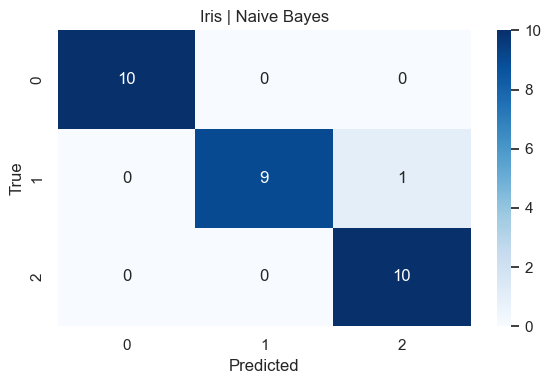


Training model: Decision Tree
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=2, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=2, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=2, clf__min_samples_split=2; total time=   0.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_

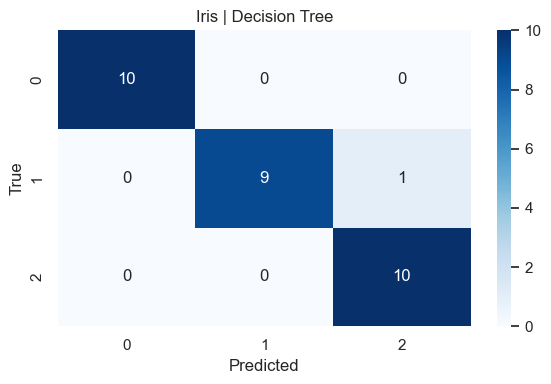


Training model: MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.001; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(50,), clf__learning_rate_init=0.01; total time=   0.0s
[C

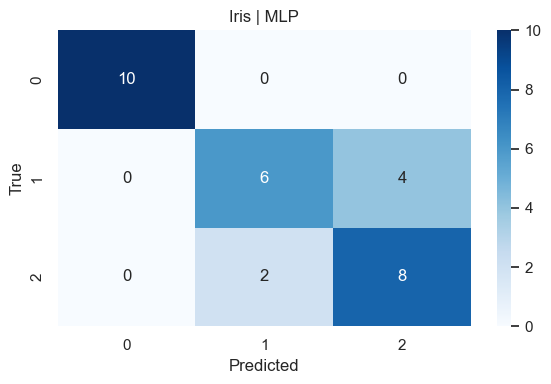


===== Summary table: Iris results =====


,model,best_params,cv_best_accuracy,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
0,Naive Bayes,{'clf__var_smoothing': 1e-09},0.950000,0.966667,0.966583,0.969697,0.966667
1,Decision Tree,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.958333,0.966667,0.966583,0.969697,0.966667
2,MLP,"{'clf__activation': 'tanh', 'clf__alpha': 0.00...",0.891667,0.800000,0.797980,0.805556,0.800000


In [33]:
cv_iris = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

results_iris_rows = []
best_models_iris = {}

for model_name, cfg in models_iris.items():
    print("\n========================================")
    print(f"Training model: {model_name}")
    print("========================================")

    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["param_grid"],
        cv=cv_iris,
        scoring="accuracy",
        n_jobs=-1,
        verbose=2,
    )

    # ---- TRAINING ----
    grid.fit(X_train_iris, y_train_iris)

    print(f"\nBest params for {model_name}:")
    print(grid.best_params_)
    print(f"Best CV accuracy for {model_name}: {grid.best_score_:.4f}")

    # store best model
    best_models_iris[model_name] = grid.best_estimator_

    # ---- TEST EVALUATION ----
    test_metrics = evaluate_on_test(grid.best_estimator_, X_test_iris, y_test_iris)

    print(f"\nTest accuracy for {model_name}: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (weighted) for {model_name}: {test_metrics['f1_weighted']:.4f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_test_iris,
            test_metrics["y_pred"],
            zero_division=0
        )
    )

    # Confusion matrix plot:
    labels_numeric = test_metrics["labels"]          # e.g. [0 1 2]
    display_labels = [class_names_iris[i] for i in labels_numeric]

    plot_confusion_matrix(
        test_metrics["confusion_matrix"],
        labels_numeric,
        title=f"Iris | {model_name}",
    )

    # Results table row
    results_iris_rows.append(
        {
            "model": model_name,
            "best_params": grid.best_params_,
            "cv_best_accuracy": grid.best_score_,
            "test_accuracy": test_metrics["accuracy"],
            "test_f1_weighted": test_metrics["f1_weighted"],
            "test_precision_weighted": test_metrics["precision_weighted"],
            "test_recall_weighted": test_metrics["recall_weighted"],
        }
    )

# Final summary table
results_iris = pd.DataFrame(results_iris_rows)
print("\n===== Summary table: Iris results =====")
display(results_iris)

### Visualise MLP Training Dynamics (Iris)

- Defines a helper function `plot_mlp_curves(...)` that:
  - Extracts the fitted `MLPClassifier` (`clf`) from the best Iris pipeline.
  - Reads `loss_curve_` (training loss per epoch) and `validation_scores_` (validation accuracy per epoch), if available.
  - Plots:
    - Training loss vs. epoch.
    - Validation accuracy vs. epoch (only if `validation_scores_` exists).
- These curves help us see how quickly the MLP converges and whether there are signs of overfitting or unstable training.

In [34]:
def plot_mlp_curves(best_mlp_pipeline, title_prefix="Iris"):
    """Plot loss_curve_ and validation_scores_ for the MLP inside the pipeline."""
    mlp_clf = best_mlp_pipeline.named_steps["clf"]

    loss_curve = getattr(mlp_clf, "loss_curve_", None)
    val_scores = getattr(mlp_clf, "validation_scores_", None)

    if loss_curve is None:
        print("No loss_curve_ found on MLP classifier.")
        return

    epochs = range(1, len(loss_curve) + 1)

    # Train loss
    plt.figure()
    plt.plot(epochs, loss_curve, label="Train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - MLP Training Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Validation accuracy (if available)
    if val_scores is not None:
        plt.figure()
        plt.plot(epochs, val_scores, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} - MLP Validation Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("validation_scores_ not available (maybe early_stopping=False?).")

### Plot MLP Curves for Iris

- Calls `plot_mlp_curves(...)` on the best Iris MLP pipeline.
- Generates the training loss and validation accuracy plots for the Iris MLP model.

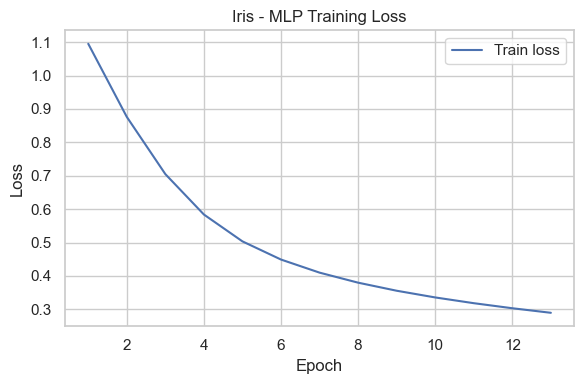

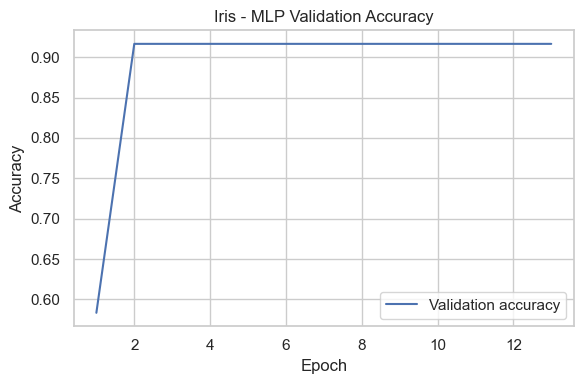

In [35]:
plot_mlp_curves(best_models_iris["MLP"], title_prefix="Iris")

## Part B – In-Context Learning (LLM) on Iris

In [36]:
# Map numeric codes 0/1/2 -> species names
label_map_iris = {
    0: "setosa",
    1: "versicolor",
    2: "virginica",
}

# Training data with human-readable labels
iris_train_for_llm = X_train_iris.copy()
iris_train_for_llm["target"] = y_train_iris.map(label_map_iris)

# Test data + true labels (for later evaluation)
iris_test_for_llm = X_test_iris.copy()
iris_test_true_labels = y_test_iris.map(label_map_iris)

# Pick a small few-shot training set (5 examples)
few_shot_iris = iris_train_for_llm.sample(n=5, random_state=RANDOM_STATE)

# For Iris, test split is small (~30 rows), so we can use the full test set
test_subset_iris = iris_test_for_llm.reset_index(drop=True)

print("Few-shot Iris training examples (with labels):")
display(few_shot_iris)

print("\nFull Iris test split (features only):")
display(test_subset_iris)

print("\nTrue labels for test split (for evaluation only, not shown to LLM):")
display(iris_test_true_labels.reset_index(drop=True))


Few-shot Iris training examples (with labels):


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
1,4.9,3.0,1.4,0.2,setosa
35,5.0,3.2,1.2,0.2,setosa
89,5.5,2.5,4.0,1.3,versicolor
149,5.9,3.0,5.1,1.8,virginica
111,6.4,2.7,5.3,1.9,virginica



Full Iris test split (features only):


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.4,3.0,1.3,0.2
1,6.1,3.0,4.9,1.8
2,4.9,2.4,3.3,1.0
3,5.0,2.3,3.3,1.0
4,4.4,3.2,1.3,0.2
5,6.3,3.3,4.7,1.6
6,4.6,3.6,1.0,0.2
7,5.4,3.4,1.7,0.2
8,6.5,3.0,5.2,2.0
9,5.4,3.0,4.5,1.5



True labels for test split (for evaluation only, not shown to LLM):


0         setosa
1      virginica
2     versicolor
3     versicolor
4         setosa
5     versicolor
6         setosa
7         setosa
8      virginica
9     versicolor
10     virginica
11     virginica
12     virginica
13    versicolor
14        setosa
15        setosa
16        setosa
17    versicolor
18    versicolor
19     virginica
20        setosa
21     virginica
22    versicolor
23     virginica
24     virginica
25    versicolor
26    versicolor
27        setosa
28     virginica
29        setosa
Name: target, dtype: object

In [37]:
def format_iris_example(row, include_label=True):
    text = (
        f"sepal length: {row['sepal length (cm)']}, "
        f"sepal width: {row['sepal width (cm)']}, "
        f"petal length: {row['petal length (cm)']}, "
        f"petal width: {row['petal width (cm)']}"
    )
    if include_label:
        text += f" -> species: {row['target']}"
    return text

print("### FEW-SHOT TRAINING EXAMPLES (copy into LLM prompt)\n")
for i, (_, r) in enumerate(few_shot_iris.iterrows(), start=1):
    print(f"Example {i}: {format_iris_example(r, include_label=True)}")

print("\n### TEST EXAMPLES (LLM must predict species)\n")
for i, (_, r) in enumerate(test_subset_iris.iterrows(), start=1):
    text = (
        f"sepal length: {r['sepal length (cm)']}, "
        f"sepal width: {r['sepal width (cm)']}, "
        f"petal length: {r['petal length (cm)']}, "
        f"petal width: {r['petal width (cm)']}"
    )
    print(f"Input {i}: {text}")

### FEW-SHOT TRAINING EXAMPLES (copy into LLM prompt)

Example 1: sepal length: 4.9, sepal width: 3.0, petal length: 1.4, petal width: 0.2 -> species: setosa
Example 2: sepal length: 5.0, sepal width: 3.2, petal length: 1.2, petal width: 0.2 -> species: setosa
Example 3: sepal length: 5.5, sepal width: 2.5, petal length: 4.0, petal width: 1.3 -> species: versicolor
Example 4: sepal length: 5.9, sepal width: 3.0, petal length: 5.1, petal width: 1.8 -> species: virginica
Example 5: sepal length: 6.4, sepal width: 2.7, petal length: 5.3, petal width: 1.9 -> species: virginica

### TEST EXAMPLES (LLM must predict species)

Input 1: sepal length: 4.4, sepal width: 3.0, petal length: 1.3, petal width: 0.2
Input 2: sepal length: 6.1, sepal width: 3.0, petal length: 4.9, petal width: 1.8
Input 3: sepal length: 4.9, sepal width: 2.4, petal length: 3.3, petal width: 1.0
Input 4: sepal length: 5.0, sepal width: 2.3, petal length: 3.3, petal width: 1.0
Input 5: sepal length: 4.4, sepal width: 3.2,

In [38]:
# True labels for Iris test split (as species names)
true_subset_iris = iris_test_true_labels.reset_index(drop=True)

llm_preds_iris_gpt = [
    "setosa",
    "virginica",
    "versicolor",
    "versicolor",
    "setosa",
    "versicolor",
    "setosa",
    "setosa",
    "virginica",
    "versicolor",
    "virginica",
    "virginica",
    "virginica",
    "versicolor",
    "setosa",
    "setosa",
    "setosa",
    "versicolor",
    "versicolor",
    "virginica",
    "setosa",
    "virginica",
    "versicolor",
    "virginica",
    "virginica",
    "versicolor",
    "versicolor",
    "setosa",
    "virginica",
    "setosa",
]

# Convert to Series for easier comparison
llm_preds_iris_gpt = pd.Series(llm_preds_iris_gpt, name="gpt_pred")

# Sanity check: lengths should match
print("Length of GPT predictions:", len(llm_preds_iris_gpt))
print("Length of true labels:    ", len(true_subset_iris))

# Comparison table (optional, for inspection)
comparison_df_iris_gpt = pd.DataFrame({
    "true": true_subset_iris,
    "gpt_pred": llm_preds_iris_gpt,
})
print("\nGPT predictions vs true labels (first 10 rows):")
display(comparison_df_iris_gpt.head(10))

# Simple accuracy on this test split
acc_gpt_iris = (llm_preds_iris_gpt == true_subset_iris).mean()
print(f"\nGPT accuracy on Iris test split: {acc_gpt_iris:.4f}")

Length of GPT predictions: 30
Length of true labels:     30

GPT predictions vs true labels (first 10 rows):


,true,gpt_pred
0,setosa,setosa
1,virginica,virginica
2,versicolor,versicolor
3,versicolor,versicolor
4,setosa,setosa
5,versicolor,versicolor
6,setosa,setosa
7,setosa,setosa
8,virginica,virginica
9,versicolor,versicolor



GPT accuracy on Iris test split: 1.0000


“On the Iris test split (30 instances), GPT achieved 100% accuracy with a simple few-shot prompt, matching or slightly exceeding the tuned classical models.”

In [39]:
# ==== HELPER: Add GPT (ICL) row + bar plots per dataset ====

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def add_llm_row_and_plot(results_df, dataset_name,
                          gpt_test_accuracy,
                          gpt_precision_weighted,
                          gpt_recall_weighted,
                          gpt_f1_weighted):
    """
    Takes the existing results_df (NB / DT / MLP),
    appends one row for GPT (ICL), and plots bar charts for
    test_accuracy and test_f1_weighted.
    """
    gpt_row = {
        "model": "GPT (ICL)",
        "best_params": "N/A",
        "cv_best_accuracy": np.nan,
        "test_accuracy": gpt_test_accuracy,
        "test_f1_weighted": gpt_f1_weighted,
        "test_precision_weighted": gpt_precision_weighted,
        "test_recall_weighted": gpt_recall_weighted,
    }

    results_with_llm = pd.concat(
        [results_df, pd.DataFrame([gpt_row])],
        ignore_index=True,
    )

    print(f"\n{dataset_name} – results including GPT (ICL):")
    display(results_with_llm[["model", "test_accuracy", "test_f1_weighted"]])

    for metric in ["test_accuracy", "test_f1_weighted"]:
        plt.figure(figsize=(6, 4))
        sns.barplot(data=results_with_llm, x="model", y=metric)
        plt.ylim(0, 1.05)
        plt.title(f"{dataset_name} – {metric.replace('_',' ').title()} (NB / DT / MLP / GPT)")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

    return results_with_llm

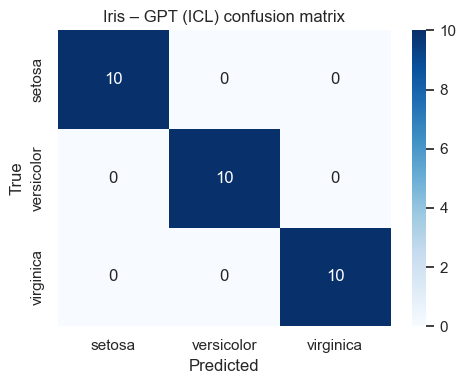

In [40]:
# ==== IRIS – GPT (ICL) confusion matrix ====

import numpy as np

cm_iris_gpt = np.diag([10, 10, 10])  # 10 setosa, 10 versicolor, 10 virginica all correct
iris_labels = ["setosa", "versicolor", "virginica"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm_iris_gpt, annot=True, fmt="d", cmap="Blues",
            xticklabels=iris_labels, yticklabels=iris_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Iris – GPT (ICL) confusion matrix")
plt.tight_layout()
plt.show()


Iris – results including GPT (ICL):


,model,test_accuracy,test_f1_weighted
0,Naive Bayes,0.966667,0.966583
1,Decision Tree,0.966667,0.966583
2,MLP,0.800000,0.797980
3,GPT (ICL),1.000000,1.000000


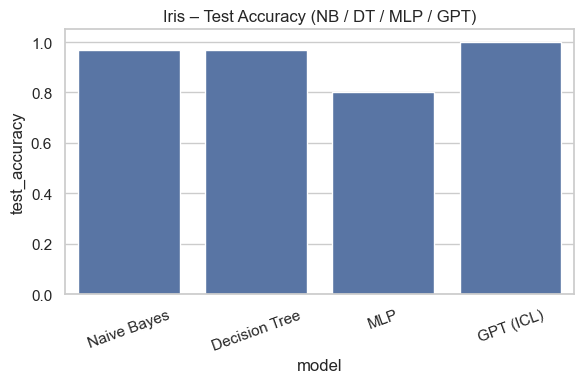

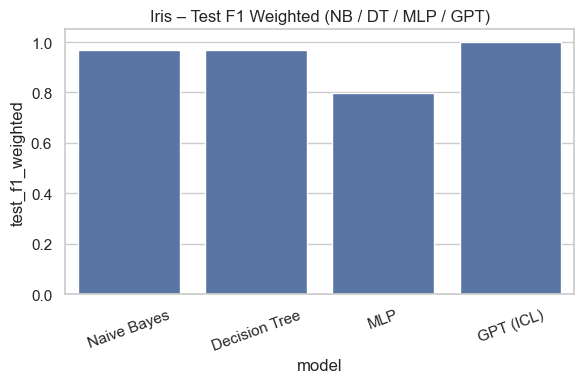

In [41]:
# ==== IRIS – add GPT to results_iris and plot comparison ====

results_iris_with_llm = add_llm_row_and_plot(
    results_iris,
    dataset_name="Iris",
    gpt_test_accuracy=1.0,
    gpt_precision_weighted=1.0,
    gpt_recall_weighted=1.0,
    gpt_f1_weighted=1.0,
)